In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras_self_attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=81e904f08c9b0ed0258ab7c6a32e06b04ba61a12942583c5036ce144ea67a118
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Cross-validation scores: [0.737949788570404, 0.72826087474823, 0.7255434989929199, 0.7316576242446899, 0.741847813129425]
Mean cross-validation score: 0.7330519199371338
Confusion Matrix (Average):
[[485 257]
 [136 594]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71      3709
           1       0.70      0.81      0.75      3652

    accuracy                           0.73      7361
   macro avg       0.74      0.73      0.73      7361
weighted avg       0.74      0.73      0.73      7361



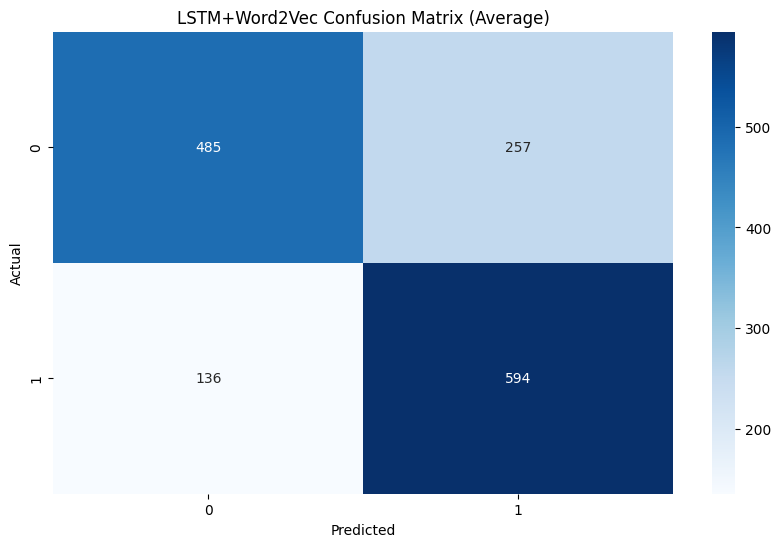

In [ ]:
##attention LSTM+word2vec
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention
from gensim.models import Word2Vec

# Veri ön işleme fonksiyonu
def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-/:;<=>[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower()
    text = text.strip()
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words_filtered)

# Veriyi yükle
xt = pd.read_excel('/content/drive/My Drive/son_dosyalar/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)

# Veriyi ayırma
X = xt['mesaj']
y = xt['label']

# Etiketleri sayısal değerlere dönüştür
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Metinleri kelime listelerine çevirme ve Word2Vec modelini eğitme
X_processed = [text.split() for text in X]
word2vec_model = Word2Vec(sentences=X_processed, vector_size=128, window=5, min_count=1, workers=4, sg=1)

# Kelime vektörlerini elde etme
max_len = 100
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 128))
for i, word in enumerate(word2vec_model.wv.index_to_key):
    embedding_matrix[i + 1] = word2vec_model.wv[word]

# Metinleri sayılara dönüştürme
def get_word2vec_sequences(texts):
    sequences = []
    for text in texts:
        sequence = []
        for word in text.split():
            if word in word2vec_model.wv:
                sequence.append(word2vec_model.wv.key_to_index[word] + 1)
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_len)

X_pad = get_word2vec_sequences(X)

# Model oluşturma fonksiyonu
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, output_dim=128, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(128, return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
conf_matrix_sum = np.zeros((len(np.unique(y_encoded)), len(np.unique(y_encoded))), dtype=np.float32)
all_y_pred = []
all_y_test = []

for train, test in kfold.split(X_pad, y_encoded):
    model = create_model()
    model.fit(X_pad[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    model.save('text_classification_model.h5')
    scores = model.evaluate(X_pad[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix hesaplama ve toplama
    conf_matrix = confusion_matrix(y_encoded[test], y_pred_classes)
    conf_matrix_sum += conf_matrix

    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test])

# Confusion Matrix ortalaması
conf_matrix_avg = np.round(conf_matrix_sum / kfold.get_n_splits()).astype(int)

# Cross-validation sonuçları
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# Confusion Matrix ve Classification Report
print("Confusion Matrix (Average):")
print(conf_matrix_avg)

target_names = [str(cls) for cls in label_encoder.classes_]
class_report = classification_report(all_y_test, all_y_pred, target_names=target_names)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix görselleştirme
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_avg, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('LSTM+Word2Vec Confusion Matrix (Average)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention

# Önceden eğitilmiş modelin yüklenmesi
model = load_model('text_classification_model.h5', custom_objects={'SeqSelfAttention': SeqSelfAttention})

# Tokenizer'ı tanımlama ve eğitme
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)  # X, metin verilerini içeren bir liste veya DataFrame olmalıdır

# Maksimum dizi uzunluğu
max_len = 100  # Önceden belirlenmiş bir değer olmalıdır

# Kullanıcıdan metin girişi al
def classify_message(message):
    # Metin ön işleme
    message = process_msg(message)

    # Metni sayılara dönüştürme
    message_seq = tokenizer.texts_to_sequences([message])

    # Dizi uzunluğunu ayarlama
    message_pad = pad_sequences(message_seq, maxlen=max_len)

    # Modeli kullanarak sınıflandırma
    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)

    # Sınıflandırma sonucunu geri döndürme
    return label_encoder.inverse_transform(prediction_class)[0]

# Komut satırı aracı
if __name__ == "__main__":
    print("Metin sınıflandırma aracına hoş geldiniz. Çıkış yapmak için 'q' girin.")
    while True:
        message = input("Sınıflandırmak istediğiniz metni girin: ")
        if message.lower() == 'q':
            print("Çıkış yapılıyor...")
            break
        prediction = classify_message(message)
        print(f"Tahmin: {prediction}")

Metin sınıflandırma aracına hoş geldiniz. Çıkış yapmak için 'q' girin.
Sınıflandırmak istediğiniz metni girin: salak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: deli
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: q
Çıkış yapılıyor...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Cross-validation scores: [0.8411405086517334, 0.8369565010070801, 0.838994562625885, 0.83763587474823, 0.817255437374115]
Mean cross-validation score: 0.8343965768814087

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3709
           1       0.85      0.81      0.83      3652

    accuracy                           0.83      7361
   macro avg       0.84      0.83      0.83      7361
weighted avg       0.84      0.83      0.83      7361



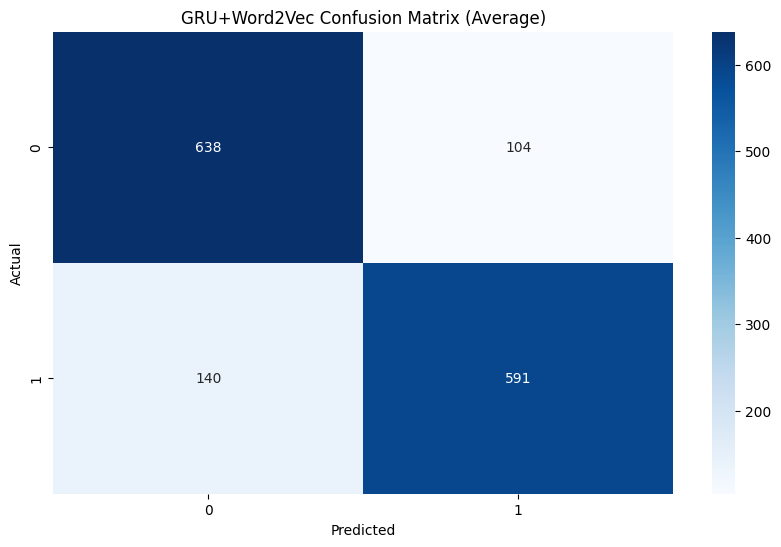

In [ ]:
#attention GRU+word2vec
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention
from gensim.models import Word2Vec

# Veri ön işleme
def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-./:;<=>[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower()
    text = text.strip()
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words_filtered)

# Veriyi yükle
xt = pd.read_excel('/content/drive/My Drive/son_dosyalar/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)

# Veriyi ayırma ve etiketleri dönüştürme
X = xt['mesaj']
y = xt['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Word2Vec modeli
X_processed = [text.split() for text in X]
word2vec_model = Word2Vec(sentences=X_processed, vector_size=128, window=5, min_count=1, workers=4, sg=1)
max_len = 100
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 128))
for i, word in enumerate(word2vec_model.wv.index_to_key):
    embedding_matrix[i + 1] = word2vec_model.wv[word]

# Metinleri sayılara dönüştürme
def get_word2vec_sequences(texts):
    sequences = []
    for text in texts:
        sequence = []
        for word in text.split():
            if word in word2vec_model.wv:
                sequence.append(word2vec_model.wv.key_to_index[word] + 1)
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_len)

X_pad = get_word2vec_sequences(X)
max_words = len(word2vec_model.wv.key_to_index) + 1
num_classes = len(np.unique(y_encoded))

# Model oluşturma
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))  # Attention katmanı eklendi
    model.add(Dropout(0.5))
    model.add(GRU(64))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Çıkış katmanı
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Model eğitimi ve k-fold çapraz doğrulama
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
conf_matrix_sum = np.zeros((len(np.unique(y_encoded)), len(np.unique(y_encoded))), dtype=np.float32)
all_y_pred = []
all_y_test = []

for train, test in kfold.split(X_pad, y_encoded):
    model = create_model()
    model.fit(X_pad[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix hesaplama ve toplama
    conf_matrix = confusion_matrix(y_encoded[test], y_pred_classes)
    conf_matrix_sum += conf_matrix

    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test])

# Confusion Matrix ortalaması
conf_matrix_avg = np.round(conf_matrix_sum / kfold.get_n_splits()).astype(int)

# Performans değerlendirme ve görselleştirme
target_names = [str(cls) for cls in label_encoder.classes_]
class_report = classification_report(all_y_test, all_y_pred, target_names=target_names)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")
print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_avg, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('GRU+Word2Vec Confusion Matrix (Average)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention

# Önceden eğitilmiş modelin yüklenmesi
model = load_model('text_classification_model.h5', custom_objects={'SeqSelfAttention': SeqSelfAttention})

# Tokenizer'ı tanımlama ve eğitme
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)  # X, metin verilerini içeren bir liste veya DataFrame olmalıdır

# Maksimum dizi uzunluğu
max_len = 100  # Önceden belirlenmiş bir değer olmalıdır

# Kullanıcıdan metin girişi al
def classify_message(message):
    # Metin ön işleme
    message = process_msg(message)

    # Metni sayılara dönüştürme
    message_seq = tokenizer.texts_to_sequences([message])

    # Dizi uzunluğunu ayarlama
    message_pad = pad_sequences(message_seq, maxlen=max_len)

    # Modeli kullanarak sınıflandırma
    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)

    # Sınıflandırma sonucunu geri döndürme
    return label_encoder.inverse_transform(prediction_class)[0]

# Komut satırı aracı
if __name__ == "__main__":
    print("Metin sınıflandırma aracına hoş geldiniz. Çıkış yapmak için 'q' girin.")
    while True:
        message = input("Sınıflandırmak istediğiniz metni girin: ")
        if message.lower() == 'q':
            print("Çıkış yapılıyor...")
            break
        prediction = classify_message(message)
        print(f"Tahmin: {prediction}")

Metin sınıflandırma aracına hoş geldiniz. Çıkış yapmak için 'q' girin.
Sınıflandırmak istediğiniz metni girin: salak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: deli
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: iyisin hadi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: q
Çıkış yapılıyor...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Cross-validation scores: [0.8452138304710388, 0.8430706262588501, 0.8505434989929199, 0.8349184989929199, 0.851222813129425]
Mean cross-validation score: 0.8449938535690308

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3709
           1       0.87      0.81      0.84      3652

    accuracy                           0.84      7361
   macro avg       0.85      0.84      0.84      7361
weighted avg       0.85      0.84      0.84      7361



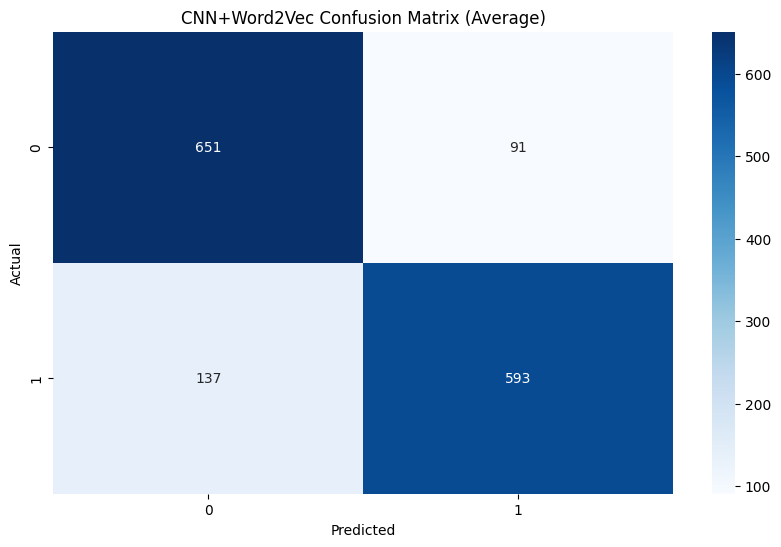

In [ ]:
#attention CNN+word2vec
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention
from gensim.models import Word2Vec

# Veri ön işleme
def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-./:;<=>[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower()
    text = text.strip()
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words_filtered)

# Veriyi yükle
xt = pd.read_excel('/content/drive/My Drive/son_dosyalar/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)

# Veriyi ayırma ve etiketleri dönüştürme
X = xt['mesaj']
y = xt['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Word2Vec modeli
X_processed = [text.split() for text in X]
word2vec_model = Word2Vec(sentences=X_processed, vector_size=128, window=5, min_count=1, workers=4, sg=1)
max_len = 100
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 128))
for i, word in enumerate(word2vec_model.wv.index_to_key):
    embedding_matrix[i + 1] = word2vec_model.wv[word]

# Metinleri sayılara dönüştürme
def get_word2vec_sequences(texts):
    sequences = []
    for text in texts:
        sequence = []
        for word in text.split():
            if word in word2vec_model.wv:
                sequence.append(word2vec_model.wv.key_to_index[word] + 1)
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_len)

X_pad = get_word2vec_sequences(X)
max_words = len(word2vec_model.wv.key_to_index) + 1
num_classes = len(np.unique(y_encoded))

# Model oluşturma
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))  # Konvolüsyon katmanı
    model.add(MaxPooling1D(pool_size=2))  # Max pooling katmanı
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))  # İkinci konvolüsyon katmanı
    model.add(MaxPooling1D(pool_size=2))  # İkinci max pooling katmanı
    model.add(SeqSelfAttention(attention_activation='sigmoid'))  # Attention katmanı
    model.add(GlobalMaxPooling1D())  # Global max pooling katmanı
    model.add(Dropout(0.5))  # Dropout katmanı
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Çıkış katmanı
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# Model eğitimi ve k-fold çapraz doğrulama
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
conf_matrix_sum = np.zeros((len(np.unique(y_encoded)), len(np.unique(y_encoded))), dtype=np.float32)
all_y_pred = []
all_y_test = []

for train, test in kfold.split(X_pad, y_encoded):
    model = create_model()
    model.fit(X_pad[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix hesaplama ve toplama
    conf_matrix = confusion_matrix(y_encoded[test], y_pred_classes)
    conf_matrix_sum += conf_matrix

    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test])

# Confusion Matrix ortalaması
conf_matrix_avg = np.round(conf_matrix_sum / kfold.get_n_splits()).astype(int)

# Performans değerlendirme ve görselleştirme
target_names = [str(cls) for cls in label_encoder.classes_]
class_report = classification_report(all_y_test, all_y_pred, target_names=target_names)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")
print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_avg, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('CNN+Word2Vec Confusion Matrix (Average)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention

# Önceden eğitilmiş modelin yüklenmesi
model = load_model('text_classification_model.h5', custom_objects={'SeqSelfAttention': SeqSelfAttention})

# Tokenizer'ı tanımlama ve eğitme
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)  # X, metin verilerini içeren bir liste veya DataFrame olmalıdır

# Maksimum dizi uzunluğu
max_len = 100  # Önceden belirlenmiş bir değer olmalıdır

# Kullanıcıdan metin girişi al
def classify_message(message):
    # Metin ön işleme
    message = process_msg(message)

    # Metni sayılara dönüştürme
    message_seq = tokenizer.texts_to_sequences([message])

    # Dizi uzunluğunu ayarlama
    message_pad = pad_sequences(message_seq, maxlen=max_len)

    # Modeli kullanarak sınıflandırma
    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)

    # Sınıflandırma sonucunu geri döndürme
    return label_encoder.inverse_transform(prediction_class)[0]

# Komut satırı aracı
if __name__ == "__main__":
    print("Metin sınıflandırma aracına hoş geldiniz. Çıkış yapmak için 'q' girin.")
    while True:
        message = input("Sınıflandırmak istediğiniz metni girin: ")
        if message.lower() == 'q':
            print("Çıkış yapılıyor...")
            break
        prediction = classify_message(message)
        print(f"Tahmin: {prediction}")

Metin sınıflandırma aracına hoş geldiniz. Çıkış yapmak için 'q' girin.
Sınıflandırmak istediğiniz metni girin: güzel 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: hadi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: köpek
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: q
Çıkış yapılıyor...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Cross-validation scores: [0.723014235496521, 0.7384510636329651, 0.74388587474823, 0.7228260636329651, 0.741847813129425]
Mean cross-validation score: 0.7340050101280212

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.63      0.70      3709
           1       0.69      0.84      0.76      3652

    accuracy                           0.73      7361
   macro avg       0.75      0.73      0.73      7361
weighted avg       0.75      0.73      0.73      7361



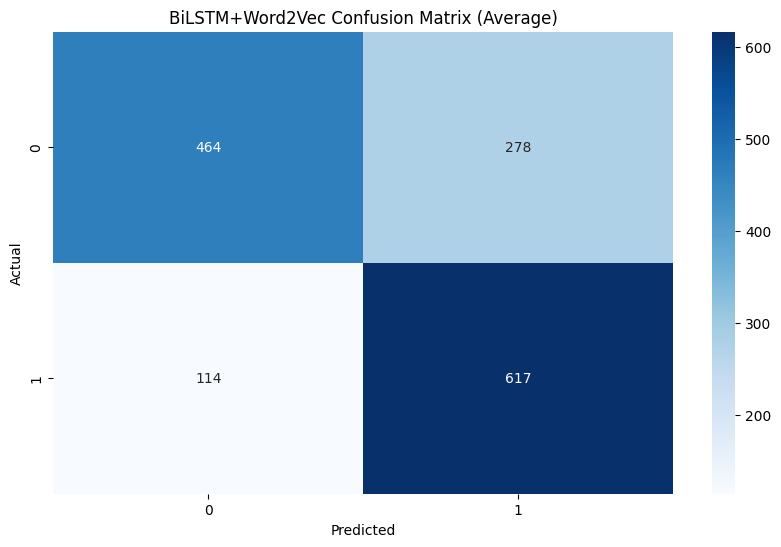

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention
from gensim.models import Word2Vec

# Veri ön işleme fonksiyonu
def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-/:;<=>[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower()
    text = text.strip()
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words_filtered)

# Veriyi yükle
xt = pd.read_excel('/content/drive/My Drive/son_dosyalar/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)

# Veriyi ayırma
X = xt['mesaj']
y = xt['label']

# Etiketleri sayısal değerlere dönüştür
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Metinleri kelime listelerine çevirme ve Word2Vec modelini eğitme
X_processed = [text.split() for text in X]
word2vec_model = Word2Vec(sentences=X_processed, vector_size=128, window=5, min_count=1, workers=4, sg=1)

# Kelime vektörlerini elde etme
max_len = 100
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 128))
for i, word in enumerate(word2vec_model.wv.index_to_key):
    embedding_matrix[i + 1] = word2vec_model.wv[word]

# Metinleri sayılara dönüştürme
def get_word2vec_sequences(texts):
    sequences = []
    for text in texts:
        sequence = []
        for word in text.split():
            if word in word2vec_model.wv:
                sequence.append(word2vec_model.wv.key_to_index[word] + 1)
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_len)

X_pad = get_word2vec_sequences(X)

# Model oluşturma fonksiyonu
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, output_dim=128, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))  # BiLSTM katmanı
    model.add(SeqSelfAttention(attention_activation='sigmoid'))  # Attention katmanı
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))  # BiLSTM katmanı
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Çıkış katmanı
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
conf_matrix_sum = np.zeros((len(np.unique(y_encoded)), len(np.unique(y_encoded))), dtype=np.float32)
all_y_pred = []
all_y_test = []

for train, test in kfold.split(X_pad, y_encoded):
    model = create_model()
    model.fit(X_pad[train], y_encoded[train], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test], y_encoded[test], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix hesaplama ve toplama
    conf_matrix = confusion_matrix(y_encoded[test], y_pred_classes)
    conf_matrix_sum += conf_matrix

    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test])

# Confusion Matrix ortalaması
conf_matrix_avg = np.round(conf_matrix_sum / kfold.get_n_splits()).astype(int)

# Performans değerlendirme ve görselleştirme
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# `target_names`'i string listesi olarak ayarlayın
target_names = [str(cls) for cls in label_encoder.classes_]
class_report = classification_report(all_y_test, all_y_pred, target_names=target_names)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix görselleştirme
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_avg, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('BiLSTM+Word2Vec Confusion Matrix (Average)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention

# Önceden eğitilmiş modelin yüklenmesi
model = load_model('text_classification_model.h5', custom_objects={'SeqSelfAttention': SeqSelfAttention})

# Tokenizer'ı tanımlama ve eğitme
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)  # X, metin verilerini içeren bir liste veya DataFrame olmalıdır

# Maksimum dizi uzunluğu
max_len = 100  # Önceden belirlenmiş bir değer olmalıdır

# Kullanıcıdan metin girişi al
def classify_message(message):
    # Metin ön işleme
    message = process_msg(message)

    # Metni sayılara dönüştürme
    message_seq = tokenizer.texts_to_sequences([message])

    # Dizi uzunluğunu ayarlama
    message_pad = pad_sequences(message_seq, maxlen=max_len)

    # Modeli kullanarak sınıflandırma
    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)

    # Sınıflandırma sonucunu geri döndürme
    return label_encoder.inverse_transform(prediction_class)[0]

# Komut satırı aracı
if __name__ == "__main__":
    print("Metin sınıflandırma aracına hoş geldiniz. Çıkış yapmak için 'q' girin.")
    while True:
        message = input("Sınıflandırmak istediğiniz metni girin: ")
        if message.lower() == 'q':
            print("Çıkış yapılıyor...")
            break
        prediction = classify_message(message)
        print(f"Tahmin: {prediction}")

Metin sınıflandırma aracına hoş geldiniz. Çıkış yapmak için 'q' girin.
Sınıflandırmak istediğiniz metni girin: salak
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: deli
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Tahmin: 0
Sınıflandırmak istediğiniz metni girin: güzel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Tahmin: 1
Sınıflandırmak istediğiniz metni girin: q
Çıkış yapılıyor...
